# 基础知识
定义：对某一个或者一组变量X进行观察测量，将在一系列时刻$t_1,t_2,⋯,t_n$所得到的离散数字组成的序列集合，称之为时间序列。

特征：趋势、季节变动、循环波动、不规则波动
# 时间序列模型
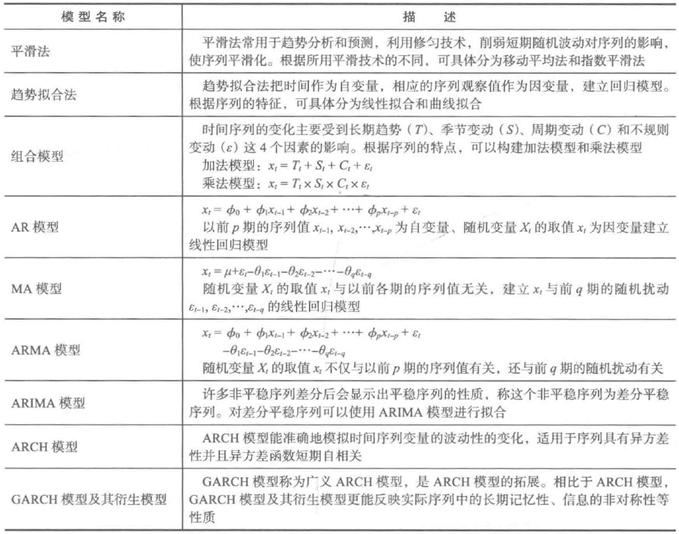
# 时间序列的预处理
1. 对于纯随机序列，又称为白噪声序列，序列的各项之间没有任何相关关系，序列在进行完全无序的随机波动，可以终止对该序列的分析。白噪声序列是没有信息可提取的平稳序列。
1. 对于平稳非白噪声序列，它的均值和方差是常数，现已有一套非常成熟的平稳序列的的建模方法。通常是建立一个线性模型来拟合该序列的发展，借此提取该序列有用信息。ARMA模型是最常用的平稳序列拟合模型。
1. 对于非平稳序列，由于它的均值和方差不稳定，处理方法一般是将其转变为平稳序列，这样就可以应用有关平稳时间序列的分析方法，如建立ARMA模型来进行相应的研究。如果一个时间序列经差分运算后具有平稳性，则该序列为差分平稳序列，可以使用ARIMA模型进行分析。
## 平稳性检验
### 直观的观察

In [1]:
# 环境配置
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import style
from statsmodels import tsa,stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体,用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

In [2]:
# tushare配置
import tushare as ts
ts.set_token('c5e635f32d3b7a8f1168362b0ca87988454155e835a5fd9ce5b43e38')
tp= ts.pro_api()

In [3]:
# 获取沪深300行情数据
indexdata=tp.index_daily(ts_code='399300.SZ',start_date='2017-01-01')
indexdata.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_change,vol,amount
0,399300.SZ,20181026,3173.6350,3204.2845,3218.1021,3151.9244,3194.3084,-20.6734,-0.6472,101299354.0,106070366.7
1,399300.SZ,20181025,3194.3084,3107.8402,3197.3212,3099.8887,3188.2018,6.1066,0.1915,106951817.0,113291746.4
2,399300.SZ,20181024,3188.2018,3169.4571,3245.3971,3164.2930,3183.4257,4.7761,0.1500,110909744.0,120954387.2
3,399300.SZ,20181023,3183.4257,3273.1271,3276.0205,3163.5704,3270.2732,-86.8475,-2.6557,121013241.0,142589176.8
4,399300.SZ,20181022,3270.2732,3159.5614,3297.3803,3159.5614,3134.9455,135.3277,4.3167,145862045.0,170651306.1


<IPython.core.display.Javascript object>


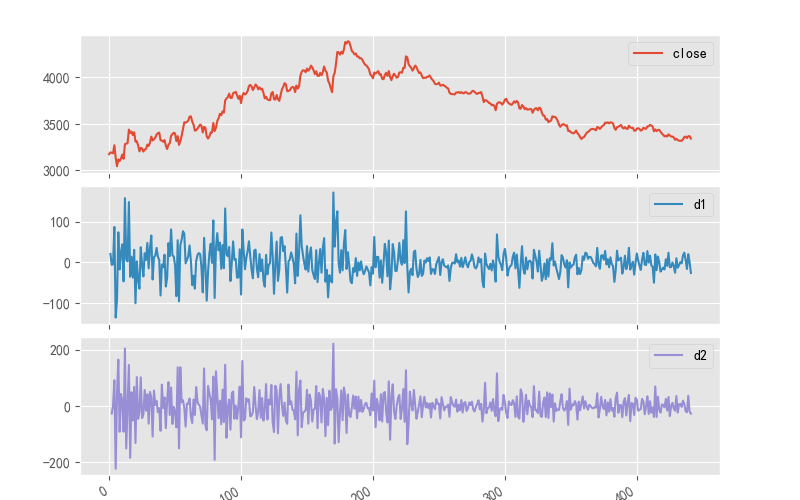

In [4]:
# 沪深300时间序列和差分序列
close=indexdata[['close']]
d1=close.diff(1)
d2=d1.diff(1)
series=pd.concat([close,d1,d2],axis=1)
series.columns=['close','d1','d2']
series.plot(subplots=True,figsize=(8,5))
plt.subplots_adjust(wspace=.1,hspace=.1,left=.1,right=.9,top=.93,bottom=0.05)  

### 定义
对于随机变量X，可以计算其均值（数学期望）μ、方差$σ^2$；对于两个随机变量X和Y，可以计算X,Y的协方差$cov(X,Y)=E[(X-μ_X)(Y-μ_Y)]$和相关系数$ρ(X,Y)=cov(X,Y)/(σ_X σ_Y )$，他们度量了两个不同事件之间的相互影响程度。<br>

对于时间序列$\{X_t,t∈T\}$，任意时刻的序列值$X_t$都是一个随机变量，每一个随机变量都会有均值和方差，记$X_t$的均值为μ_t 方差为$σ_t^2$ ；任取t,$s∈T$,定义序列$X_t$的自协方差函数$γ(t,s)=E[(X_t-μ_t)(X_s-μ_s)]$和自相关函数$ρ(t,s)=cov(X_t,X_s )/(σ_t σ_s )$，特别的，$γ(t,t)=γ(|t-t|)=γ(0)=σ_t^2,ρ(t,t)=ρ(|t-t|)= ρ(0)=1$，之所以称它们为自协方差和自相关系数，是因为它们衡量的是同一个事件在两个不同时期（时刻t和s）之间的相关程度，形象地讲就是度量自己过去的行为对自己现在的影响。

给定时间序列$\{X_t,t∈T\}$，表示任意t时刻的时间序列。其有限维度的分布为$F(x_{t1},…,x_{tn}),t1,…,tn属于T$，对于任意n，存在任意h，总有$F(x_{t1},…,x_{tn})=F(x_{t1+h},…,x_{tn+h})$，也就是说时间序列$\{X_t,t∈T\}$的联合分布在时间的平移变换下保持不变，那么称该时间序列$\{X_t,t∈T\}$**严平稳**。

如果时间序列$\{X_t,t∈T\}$ 在某一常数附近波动且波动范围有限，即有常数均值和常数方差，并且延迟k期的序列变量的自协方差和自相关系数是相等的或者说延迟k期的序列变量之间的影响程度是一样的，即$μ_t,γ(t,s),ρ(t,s)$都为常数,其中$t∈T,t≠s,t-s=c,c$为常数,，则称$\{X_t,t∈T\}$ 为通常意义上的平稳序列，即弱平稳时间序列。
### 检验
对序列的平稳性的检验有两种检验方法，一种是根据时序图和自相关图的特征做出判断的图检验，该方法操作简单、应用广泛，缺点是带有主观性；另一种是构造检验统计量进行检验的方法，目前最常用的方法是单位根检验。
## 纯随机性检验
如果一个序列是纯随机序列，那么它的序列值之间应该没有任何关系，即满足$ρ_k=0,k≠0$ 这是一种理论上才会出现的理想状态，实际上纯随机序列的样本自相关系数不会绝对为零，但是很接近零，并在零附近随机波动。

纯随机性检验也称白噪音检验，一般是构造检验统计量来检验序列的纯随机性，常用的检验统计量有Q统计量、LB统计量，由样本各延迟期数的自相关系数可以计算得到检验统计量，然后计算出对应的p值，如果p值显著大于显著性水平α，则表示该序列不能拒绝纯随机的原假设，可以停止对该序列的分析。
# 平稳时间序列分析
## AR模型
具有如下结构的模型称为p阶自回归模型，简记为$AR(p)$。
$x_t=μ+∑_{i=1}^p{ϕ_i x_{t-i}}+ε_t=ϕ_0+ϕ_1 x_{t-1}+ϕ_2 x_{t-2},…,ϕ_p x_{t-p}+ε_t$，即在t时刻的随机变量$X_t$的取值$x_t$是前p期$x_{t-1},…,x_{t-p}$的多元线性函数，认为$x_t$主要是受过去p期的序列值的影响。误差项是当期的随机干扰$ε_t$，为零均值白噪声序列。
平稳AR模型的性质如下：
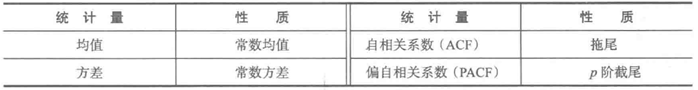
对满足平稳性条件的$AR(p)$ 模型的的方程，两边取期望，得：$E(x_t)=E(ϕ_0+ϕ_1 x_{t-1}+ϕ_2 x_{t-2},…,ϕ_p x_{t-p}+ε_t)$，已知$E(x_t )=μ,E(ε_t )=0$，所以有$μ=ϕ_0+ϕ_1 μ+,…,+ϕ_p μ$，解得：$μ=ϕ_0/(1-ϕ_1-,…,-ϕ_p )$。
$AR(p)$ 模型的方差有界，值为常数。


## MA模型
具有如下结构的模型称为q阶移动平均模型，简记为$MA (q)$。
$x_t=μ+∑_{i=1}^q{Θ_i ε_{t-i} }+ε_t=μ+Θ_1 ε_{t-1}+Θ_2 ε_{t-2},…,Θ_q ε_{t-q}+ε_t$，即在t时刻的随机变量$X_t$的取值$x_t$是前q期的随机扰动$ε_{t-1},…,ε_{t-q}$的多元线性函数。认为$x_t$主要是受过去q期的误差项的影响。
平稳MA模型的性质如下：
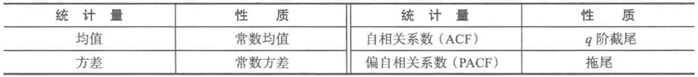

## ARMA模型
具有如下结构的模型称为自回归移动平均模型，简记为ARMA(p,q)。
$x_t=μ+∑_{i=1}^p{ϕ_i x_{t-i}}+∑_{i=1}^q{Θ_i ε_{t-i}}+ε_t$，即在t时刻的随机变量$X_t$的取值$x_t$是前p期$x_{t-1},…,x_{t-p}和前q期的随机扰动ε_{t-1},…,ε_{t-q}$的多元线性函数。认为$x_t$主要是受过去p期的序列值和q期的误差项的共同影响。特别的，当q=0时，是$AR(P)$模型，当p=0时，是$MA(q)$模型。
平稳$ARMA(p,q)$ 模型的性质如下： 
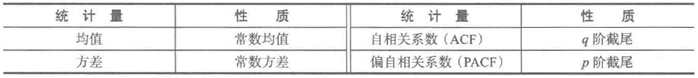
## 评判方法
### 自相关系数（ACF）
平稳$AR(p)$ 模型的自相关系数$ρ_k=ρ(t,s)=cov(X_t,X_s )/(σ_t σ_s ),k=t-s$,<br>
根据弱平稳性质$σ_s=σ_t$，有$ρ ̂_k=(∑_t^T{(X_t-\overline{X_t}))(X_s-\overline{X_s })}/(∑_t^Tσ_t^2 )$，则$ρ ̂_1,ρ ̂_2,…$称为时间序列$X_t$的样本自相关系数ACF。<br>
自相关系数呈指数的速度锐减，始终有非零取值，不会在k大于某个常数之后就恒等于零，这个性质就是平稳$AR(p) $模型的自相关系数$ρ_k$具有拖尾性。<br>
当自相关函数中所有的值都为0时，我们认为该序列是完全不相关的；因此，我们经常需要检验多个自相关系数是否为0。<br>
混成检验：<br>
原假设$H_0：ρ_1=⋯=ρ_m=0$<br>
统计量：$Q(m)=T(T+2)∑_k^m{\frac{({ρ ̂}_k)^2}{(T-k)}}$<br>
$Q(m)$渐进服从自由度为m的$χ^2$分布，如果$Q(m)>χ_α^2$，即Q(m)统计量的$pvalue≤显著性水平α，则拒绝H_0。$<br>
### ACF-混成检验

In [5]:
data=indexdata.close
m=10# 我们检验10个自相关系数
acf,q,p = sm.tsa.acf(data,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,11), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.987225,433.709620,2.532197e-96
2.0,0.975010,857.714779,5.618266e-187
3.0,0.962439,1271.797709,1.936986e-275
4.0,0.947943,1674.417649,0.000000e+00
5.0,0.937076,2068.760309,0.000000e+00
6.0,0.924513,2453.480276,0.000000e+00
7.0,0.910761,2827.698639,0.000000e+00
8.0,0.898097,3192.420472,0.000000e+00
9.0,0.885475,3547.781966,0.000000e+00


我们取显著性水平为0.05，可以看出，所有的p-value都小于0.05；则我们拒绝原假设$H_0$。因此，我们认为该序列，即沪深300指数，是序列相关的。我们再来看看同期沪深300指数的的日收益率序列：

In [6]:
data2=indexdata["pct_change"]
m=10# 我们检验10个自相关系数
acf,q,p = sm.tsa.acf(data2,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,11), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,-0.024092,0.258287,0.611300
2.0,0.013894,0.344394,0.841814
3.0,0.108844,5.640405,0.130478
4.0,-0.150363,15.770437,0.003343
5.0,0.001585,15.771565,0.007527
6.0,-0.024756,16.047415,0.013502
7.0,-0.031050,16.482365,0.021057
8.0,-0.034038,17.006261,0.030044
9.0,0.020110,17.189546,0.045829


可以看出，p-value均大于显著性水平0.05。我们选择假设$H_0$，即沪深300指数日收益率序列没有显著的相关性。
### 偏自相关系数（PACF）
对于一个平稳$AR(p)$ 模型，求出延迟k期自相关系数$ρ_k$时，实际上的得到的并不是$X_t与X_{t-k}$之间单纯的相关关系，因为$X_t$同时还会受到中间k-1个随机变量$X_{t-1},…,X_{t-k-1}$的影响，所以自相关系数$ρ_k$里实际上掺杂了其它变量对$X_t与X_{t-k}$的相关影响，为了单纯的测度$X_{t-k}$对$X_t$的影响，引进了偏自相关系数的概念。可以证明平稳$AR(p)$ 模型的偏自相关系数具有p阶截尾性。这个性质连同前面的自相关系数的拖尾性是$AR(p)$ 模型重要的识别依据。
### 截尾和拖尾
p阶自回归模型$AR(p)$ 的偏自相关函数PACF在p阶之后应为零，称其具有截尾性；自相关函数ACF不能在某一步之后为零（截尾），而是按指数衰减（或成正弦波形式)，称其具有拖尾性。

q阶移动平均模型$MA (q)$ 的自相关函数ACF在q阶之后应为零，称其具有截尾性；偏自相关函数PACF不能在某一步之后为零（截尾），而是按指数衰减（或成正弦波形式)，称其具有拖尾性。
### 截尾和拖尾判断
如果样本自相关系数（或偏自相关系数）在最初的d阶明显大于2倍标准差范围，而后几乎95%的样本自相关（偏自相关）系数都落在2倍标准差范围以内，而且由非零自相关（偏自相关）系数衰减为小值波动的过程非常突然，这时，通常视为自相关（偏自相关）系数截尾。

如果有超过5%的样本相关系数落在2倍标准差范围以外，或者是由显著非零的相关函数衰减为小值波动的过程比较缓慢或者非常连续，这时，通常视为相关系数不截尾。
## 平稳时间序列建模
某个时间序列经过预处理，被判定为平稳非白噪声序列，就可以利用$ARMA$模型进行建模。计算出平稳非白噪声序列$\{X_t,t∈T\} $的自相关系数和偏自相关系数，再由$AR(p)$模型、$MA (q)$模型、$ARMA(p,q)$模型的自相关系数ACF和偏自相关系数PACF的性质，选择合适的模型。平稳时间序列建模步骤如下图：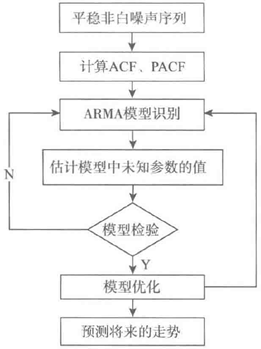
1. 计算ACF和PACF
2. ARMA(p,q) 模型识别,以下表来确定p和q，p值确定看PACF，q值确定看ACF，截尾的意义简而言之，就是落到95%置信区间内。

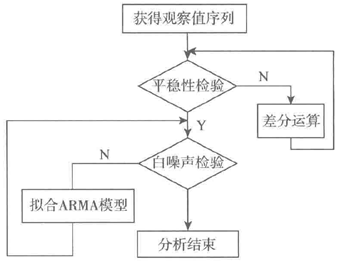
# 非平稳时间序列分析-ARIMA模型
## 差分运算
相距p期的两个序列值之间的减法运算称为p阶差分运算。
## ARIMA模型
差分运算具有强大的确定性信息提取能力，许多非平稳序列差分后会显示出平稳序列的性质，这时称这个非平稳序列为差分平稳序列。对差分平稳序列可以使用ARMA(p,q) 模型进行拟合。ARIMA(p,q) 模型的实质就是差分运算与ARMA(p,q)模型的组合，掌握了ARMA(p,q)模型的建模方法和步骤之后，对序列建立ARIMA模型是比较简单的。差分平稳时间序列建模步骤如下：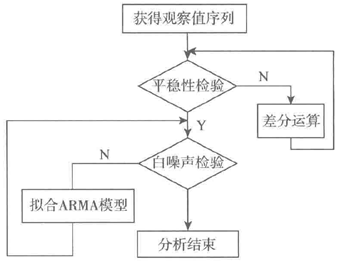